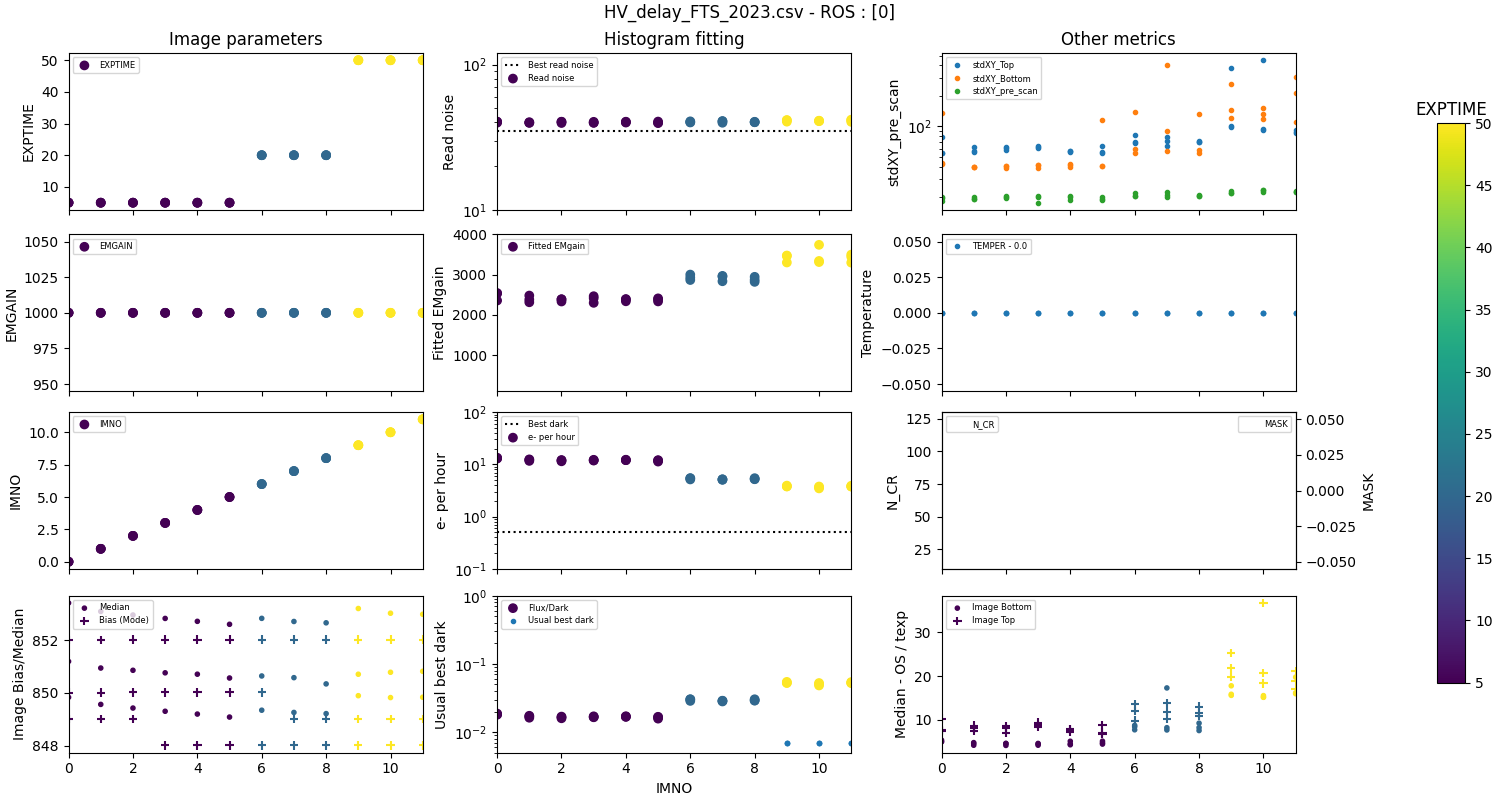

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.table import Table
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
import ipywidgets as widgets
import numpy as np
from scipy import interpolate
from datetime import datetime
import os


# x = "SECONDS_TU"
# x = "Mins_after_launch"

# for col in ["EMGAIN","N_CR","EXPTIME"]:
#     cat[col.lower()] = interpolate.interp1d(cat[x][cat["IMNO"]>1], cat[col][cat["IMNO"]>1], kind="nearest",fill_value="extrapolate")(cat[x])


def add_line(cat, y, ax, x,i=0, init=True,l=None,style='None',display=True, change=False, ylabel=None,log=False,ylim=None, c=None,fig=None,marker="o",loc="upper left",**kwargs):
    if ylabel is None:
        ylabel = y
    if display == False:
        label = None
    else:
        try:
            label = ylabel#.replace(" * 1","") + " = %.5s"%(cat.eval(y)[i])
        except KeyError as e:
            label = None#ylabel
    # print(label)
    if init:
        # if log:
        #     if display==False: 
        #         l = ax.semilogy(cat.eval(x),cat.eval(y),'none', **kwargs)
        #     else:
        #         l = ax.semilogy(cat.eval(x),cat.eval(y),".", **kwargs)
        # else:
        if display==False: 
            l = ax.scatter(cat.eval(x),cat.eval(y),c=cat.eval(c),ls='none',label=label, marker=marker, **kwargs)
            # l = ax.plot(cat.eval(x),cat.eval(y),'none', **kwargs)
        else:
            if c is not None:
                l = ax.scatter(cat.eval(x),cat.eval(y),c=cat.eval(c),ls=style,label=label, marker=marker,**kwargs)
                # fig.colorbar(l, ax=ax)
            else:
                l = ax.plot(cat.eval(x),cat.eval(y),".", **kwargs)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)      
    if change:
        l[0].set_data(cat.eval(x),cat.eval(y))
        if display==False:
            l[0].set_linestyle('none')
        else:
            l[0].set_linestyle(style.replace(".","").replace("o",""))
    try:
        l[0].set_label(label.replace("- -","+"))
    except TypeError:
        pass 
    if label is not None:
        ax.legend(loc=loc, fontsize=6)
    return l


style={}#{'description_width': 'initial'} 
width = '400px'
continuous_update=True




# from datetime import datetime
# plt.figure()
# plt.plot([datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") for i in cat["DATE"]],cat["IMNO"])
# plt.gcf().autofmt_xdate()
# plt.show()

class dashboard_detector(widgets.HBox):


    def __init__(self,x,path,query="IMNO>-1",st="None",c="EXPTIME",ylim=0,time_format= "%d/%m/%y %H:%M:%S"):
        super().__init__()


        # st="None"
        # c=color
        self.fig, self.axes = plt.subplots(4,3, figsize=(15,8),sharex=True, constrained_layout=True)
        a0, a1, a2, a3= self.axes
        self.a01_bis=a2[2].twinx()

        self.cbar=None
        self.output = widgets.Output()
        self.time_format=time_format
     
        cat = Table.read("Catalogs/Detector/" + path).to_pandas()
        # cat = update(self,path,x,query, color=c, style=st,ylim="fixed")

        self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = style, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
        # self.temps = widgets.SelectMultiple(options=[col for col in cat.columns if (("TEMP" in col)&(len(col)<7))],value=[col for col in cat.columns if (("TEMP" in col)&(len(col)<7))],rows=3,description='Temps',disabled=False)
        self.x =  widgets.Dropdown(options=["IMNO", "DATE","Mins","Seconds","EXPTIME","EMGAIN"],value=x,description='x axis',disabled=False)
        self.y =  widgets.Dropdown(options=["value", "value/exptime"],value="value",description='y axis',disabled=False)
        self.query = widgets.Combobox(options=["EXPTIME>=0 & IMNO>0 & Mins>50","EXPTIME>=0 & IMNO>20","EMGAIN>0"], layout=Layout(width='350px'),description='Query',value=query,continuous_update=False)
        # self.query = widgets.Combobox(options=["IMNO>0 & Mins>50"], layout=Layout(width='350px'),description='Query',value="IMNO>0",continuous_update=False)
        self.color =  widgets.Dropdown(options=["EXPTIME","EMGAIN","IMNO", "Mins"],value="EXPTIME",description='Color',disabled=False)
        self.path = widgets.Dropdown(options=["2018_flight.csv","2022_FTS.csv","Aafaque_2023_dark.csv","ROS_s2_caltech.csv","ROS_s2_hdr_caltech.csv","HV_delay_FTS_2023.csv"],value="HV_delay_FTS_2023.csv",description='style',disabled=False)
        self.ylim = widgets.Checkbox(value=ylim,description='ylim',disabled=False)
        # self.selection = widgets.Dropdown(options=["EXPTIME>0 & IMNO>20"],value= "EXPTIME>0 & IMNO>20",description='style',disabled=False)
        # self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
        # self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4, 5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
        # self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
        wids = widgets.interactive(self.update,t=self.t,x=self.x,y=self.y,query=self.query,color=self.color,path=self.path,ylim=self.ylim)#self.temps,,temps=self.temps,,style=self.style)#,targets=self.targets,xlim=self.xlim,GS=self.GS)
        # controls = VBox([HBox([self.t,self.temps, self.x, self.y]),   HBox([self.query,self.color]) ] ) #,self.targets,self.xlim,self.GS #,self.style
        controls = VBox([HBox([self.path, self.x,self.query,self.color,self.ylim]) ] ) #,self.targets,self.xlim,self.GS #,self.style

        display(HBox([self.output,controls]))
        self.update(path= self.path.value,x=self.x.value,query=self.query.value, color=self.color.value, style=st,ylim=ylim)

    def update(self,path,x,query, color, style=".",ylim=False): #temps,
        """Draw line in plot"""
        st="None"
        c=color
        self.rotime = 2
        with self.output:
            
            cat = Table.read("Catalogs/Detector/" + path)

            for ax in self.axes.flatten():
                ax.clear()
            self.a01_bis.clear()
            if self.cbar is not None:
                self.cbar.remove() 



                
            if  'N_CR' not in cat.colnames:
                cat['N_CR']=np.nan
            if  'MASK' not in cat.colnames:
                cat['MASK']=np.nan
            try:
                cat["DATE"] = [datetime.strptime(i, self.time_format) for i in cat["DATE"]]
            except ValueError:
                cat["DATE"] = [datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") for i in cat["DATE"]]
            except KeyError:
                cat["DATE"] = [datetime.strptime(i["OBSDATE"]+i["OBSTIME"], "%Y-%m-%d%H:%M:%S.%f") for i in cat]
                cat["EXPTIME"] = cat["R_EXP"]/1000
                cat["EMGAIN"] = 1000
                cat["e_per_hour"] = cat["hist_flux"] * 3600 / cat["EXPTIME"] 
                cat["ROS"]=0

            cat["Mins"]= [(line["DATE"]-cat["DATE"][np.argmin(cat["DATE"])]).seconds/60 for line in cat]
            cat["Seconds"]= [(line["DATE"]-cat["DATE"][np.argmin(cat["DATE"])]).seconds for line in cat]
            cat=cat.to_pandas()
            cat = cat.query(query)
            self.cat=cat
            # print(len(self.axes))
            self.a0,self.a1,self.a2,self.a3 = self.axes
            a0, a1, a2, a3= self.axes
            a3[1].set_xlabel(x)
            self.la000 =  add_line(cat,"EXPTIME",x=x,ax=a0[0],style=st,display=True,c=c,fig=self.fig)


            self.la010 =  add_line(cat,"EMGAIN",x=x,ax=a1[0],style=st,display=True,c=c,fig=self.fig)

            a0[1].axhline(35,ls=":",c="k",label="Best read noise")
            self.la220 = add_line(cat,"hist_ron",x=x,ax=a0[1],style=st,display=True,fig=self.fig,c=c,ylabel="Read noise")


            self.la100 =  add_line(cat,"N_CR",x=x,ax=a2[2],style=st,display=True,c=c,fig=self.fig,marker=".")
            self.la101 =  add_line(cat,"MASK",x=x,ax=self.a01_bis,style=st,display=True,c=c,fig=self.fig,marker="+",loc="upper right")
            # self.a01_bis=a0[1].twinx()



            self.la200=[]
            for col in cat.columns:
                if (("TEMP" in col)&(len(col)<7)):
                    try:
                        self.la200.append(add_line(cat,"%s - %0.1f"%(col,np.mean(cat[col])),x=x,ax=a1[2],style=st,display=True,fig=self.fig))
                    except TypeError:
                        pass
            a1[2].set_ylabel("Temperature")
            self.la120 = add_line(cat,y="hist_gain",x=x,ax=a1[1],style=st,display=True,log=True,fig=self.fig,c=c,ylabel="Fitted EMgain")


            self.la11 = add_line(cat,"IMNO",x=x,ax=a2[0],style='-',display=True,c=c)


            add_line(cat,"median_physical",x=x,ax=a3[0],style=st,display=True,fig=self.fig,c=c,marker=".",ylabel="Median")
            add_line(cat,"hist_bias",x=x,ax=a3[0],style=st,display=True,fig=self.fig,c=c,marker="+",ylabel="Bias (Mode)")
            a3[0].set_ylabel("Image Bias/Median")


            if "FRAC5SIG " in cat.columns:
                add_line(cat,"FRAC5SIG ",x=x,ax=a3[1],style=st,display=True,fig=self.fig)
            add_line(cat,"hist_flux",x=x,ax=a3[1],style=st,display=True,log=True,fig=self.fig,c=c,ylabel="Flux/Dark",marker="o")
            add_line(cat,y="0.5 / 3600 * EXPTIME",x=x,ax=a3[1],style=st,display=True,fig=self.fig,ylabel="Usual best dark",marker=".")

            # a3[0].set_yscale("log")
            a2[1].axhline(0.5,ls=":",c="k",label="Best dark")
            self.la210 = add_line(cat,y="e_per_hour",x=x,ax=a2[1],style=st,display=True,fig=self.fig,c=c,ylabel="e- per hour")#,marker=".")
            if "FRAC5SIG " in cat.columns:
                self.la211 = add_line(cat,y="3600*FRAC5SIG/EXPTIME",x=x,ax=a2[1],style=st,display=True,fig=self.fig)
            a2[1].set_yscale("log")
            self.la320 = add_line(cat,y="BottomImage ",x=x,ax=a3[2],style=st,display=True,fig=self.fig,c=c,marker=".",ylabel="Image Bottom")
            self.la321 = add_line(cat,y="TopImage ",x=x,ax=a3[2],style=st,display=True,fig=self.fig,c=c,marker="+",ylabel="Image Top")
            a3[2].set_ylabel("Median - OS / texp")

            self.la022 = add_line(cat,"stdXY_Top",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
            self.la023 = add_line(cat,"stdXY_Bottom",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
            self.la024 = add_line(cat,"stdXY_pre_scan",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
            a0[2].set_yscale("log")
            a0[1].set_yscale("log")
            a3[1].set_yscale("log")
            self.cbar = self.fig.colorbar(self.la210, ax=self.axes.ravel().tolist(), shrink=0.8,aspect=20)
            a0[2].set_xlim((np.nanmin(cat.eval(x)),np.nanmax(cat.eval(x))))
            # a0[2].relim()
            # a0[2].autoscale_view()
            self.cbar.ax.set_title(c)
            if ylim:
                a1[1].set_ylim((100,4000))
                a2[1].set_ylim((0.1,100))
                a2[2].set_ylim((10,130))
                a3[1].set_ylim((0.005,1))
                a0[1].set_ylim((10,120))
                # a3[2].set_ylim((-10,10))
            a0[0].set_title("Image parameters")
            a0[1].set_title("Histogram fitting")
            a0[2].set_title("Other metrics")
            # elif "%" in ylim:
                
            self.scatters = [self.la000,self.la010]
            self.fig.suptitle("%s - ROS : %s"%(os.path.basename(path), np.unique(cat["ROS"])))


            self.fig.canvas.draw()
            # self.axes = a0, a1,(a2, a3 ))
            return cat



path = "Catalogs/Detector/"


d = dashboard_detector(path="Aafaque_2023_dark.csv", query = "EXPTIME>=0",x="IMNO",c="EXPTIME",ylim=True)#IMNO & Mins>50

In [72]:
# TODO ajouter axis double en y
# TODO add smearing length
# TODO ajouter possibilité de changer axis x
# TODO ajouter possibilité de mettre une filtre
# TODO ajouter smearing, flux in slits (to be selected, etc)
# TODO ajouter valeurs usuelles
# TODO ajouter danc chaque image quel masque c'est 

# Bruits
# 1. RN
# 2. CIC
# 3. dark? / sky
# 4. gain / gain sans smearing
# 5. smearing
# Temperatures:
# 1. CR/t (avec % image lost)
# 2. temperatures
# Parametre
# 1. DAQ
# 2. Exptime
# 3. Readout sequence?
# Reduction:
# 1. Flux dans les fentes
# 2. stack?


Todo:
- put all orders (temperatures, az/el, guiding stars positions)
- add electric consumption?
- add new temperatures
- change to dates x abs
- add some tracer with t
- add BRD-VM_30MS_1-TM-MISSION1-Batterie

In [2]:



# d = dashboard_detector(path=path+"Aafaque_2023_dark.csv", query = "EXPTIME>0 & IMNO>20",x="IMNO",c="EXPTIME",ylim=100)#IMNO & Mins>50


        # cbar = self.fig.colorbar(self.la210, orientation="horizontal",aspect=100,anchor=(1,0))
        # self.la020 = add_line(cat,"std_pre_scan",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
        # self.fig.subplots_adjust(right=0.95)
        # cbar = self.fig.colorbar(self.la210, cax=self.fig.add_axes([0.99, 0.05, 0.02, 0.9]))

            # a3[1].set_ylim((0,0.1))
        # a3[2].set_yscale("log")
        # self.la322 = add_line(cat,y="LINCENC",ax=a3[2],style='-',display=True,ylabel="LIN ENC")
        # self.la021 = add_line(cat,"stdXY",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)

                # self.ax1bis = self.ax1.twinx()
        # a0[1].sharex(a0[0])
        # a0[0].get_shared_x_axes().join(a0[0],a0[1])
        # self.la100 = add_line(cat,"FRAC5SIG ",ax=a0[1],style=st,display=True,log=True,fig=self.fig)
        # self.la100 = add_line(cat,"N_CR",ax=a0[1],style=st,display=True,log=True,fig=self.fig)
        # self.la101= add_line(cat,y="MASK",x=x,ax=a3[1],style=st,display=True,fig=self.fig)
        # self.la310 = add_line(cat,y="hist_flux",x="EXPTIME",ax=a3[1],style=st,display=True,fig=self.fig,c=c)

        # self.la121 = add_line(cat,"Moon_El",ax=a1[2],style='-',display=True)
        # self.la122 = add_line(cat,"Sun_El",ax=a1[2],style='-',display=True)
        # self.la123 = add_line(cat,"F2_El",ax=a1[2],style='-',display=True)
        # self.la124 = add_line(cat,"m31_El",ax=a1[2],style='-',display=True, ylabel="Elevation")
        # for axes in self.axes:
        #     for ax in axes:
        #         ax.legend()
        # self.vlines = []
        # for axes in self.axes:
        #     for ax in axes:
        #         line = ax.axvline(x=cat[x][0], color="black", ls='--')
        #         self.vlines.append(line)

        # self.fig.tight_layout()
        # self.fig.constrained_layout()

    #     self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = style, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
    #     self.temps = widgets.SelectMultiple(options=[col for col in cat.columns if (("TEMP" in col)&(len(col)<7))],value=[col for col in cat.columns if (("TEMP" in col)&(len(col)<7))],rows=3,description='Temps',disabled=False)
    #     self.x =  widgets.Dropdown(options=["IMNO", "DATE","Mins","Seconds"],value=x,description='x axis',disabled=False)
    #     self.y =  widgets.Dropdown(options=["value", "value/exptime"],value="value",description='y axis',disabled=False)
    #     self.query = widgets.Combobox(options=["IMNO>0 & Mins>50"], layout=Layout(width='350px'),description='Query',value="IMNO>0",continuous_update=False)
    #     self.color =  widgets.Dropdown(options=["EXPTIME","EMGAIN","IMNO", "DATE"],value="EXPTIME",description='Color',disabled=False)
    #     # self.style=widgets.Dropdown(options=['-', '--o', '-.', ':', 'None', ' ', ''],value="-",rows=1,description='style',disabled=False)
    #     # self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
    #     # self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4, 5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
    #     # self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
    #     wids = widgets.interactive(self.update,t=self.t,temps=self.temps,x=self.x,y=self.y,query=self.query,color=self.color)#,style=self.style)#,targets=self.targets,xlim=self.xlim,GS=self.GS)
    #     # controls = VBox([HBox([self.t,self.temps, self.x, self.y]),   HBox([self.query,self.color]) ] ) #,self.targets,self.xlim,self.GS #,self.style
    #     controls = VBox([HBox([self.temps, self.x,self.query,self.color]) ] ) #,self.targets,self.xlim,self.GS #,self.style

    #     display(HBox([self.output,controls]))

        


    # def update(self,t,temps,x,y,query, color, style="."): #,targets,xlim,GS
    #     """Draw line in plot"""
        
    #     with self.output:
    #         a0, a1, a2, a3 = self.axes
    #         for scat in self.scatters:
    #             scat.set_array(cat[color])
    #         a0[2].relim()
    #         a0[2].autoscale_view()
    #         a0[2].relim()
    #         a0[2].autoscale_view()
    #         self.fig.canvas.draw()
    #         self.axes = a0, a1, a2, a3 
    #         return 


